#### I'm currently working on a project utilizing a Decision Tree Regressor to predict taxi tips. The dataset I'm using is publicly available, sourced from the official NYC government website. This dataset contains valuable information about taxi tips and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by authorized technology providers under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). Due to its size, the data is stored in Parquet format, and I'm leveraging the PyArrow library to efficiently access and analyze this data.

#### Finaly i will check with sklearn and snapml libraries to compare the performance

In [13]:
# install pyarrow library
# !pip install pyarrow  

import pyarrow.parquet as pq  # import the parquet instance to open the parquet file
raw_data= pq.read_table('yellow_tripdata_2023-09 .parquet') # use .read_table() function to open the parquet file
raw_data = raw_data.to_pandas() 

#### Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable and that is what I am going to predict.

In [14]:
raw_data.shape # Check the size of the dataset

(2846722, 19)

In [15]:
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,N,163,230,2,6.5,3.5,0.5,0.00,0.0,1.0,11.50,2.5,0.00
1,2,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,N,236,233,1,14.2,1.0,0.5,2.00,0.0,1.0,21.20,2.5,0.00
2,2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,N,162,236,1,8.6,1.0,0.5,2.00,0.0,1.0,15.60,2.5,0.00
3,2,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,N,141,229,1,5.1,1.0,0.5,1.00,0.0,1.0,11.10,2.5,0.00
4,2,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,N,138,230,1,45.0,6.0,0.5,17.02,0.0,1.0,73.77,2.5,1.75


### Importing libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

### Data Cleaning

In [38]:
# If the tip ammunt 0 then it means the tip has been paid in cash so eliminate those rows
raw_data=raw_data[raw_data["tip_amount"] > 0] 

# If the tip amount is larger than the fare cost then eliminate those rows
raw_data = raw_data[raw_data["tip_amount"] <= raw_data["fare_amount"]]

# Eliminate the rows which has the large fare_cost
raw_data = raw_data[((raw_data["fare_amount"] >= 2) & (raw_data["fare_amount"] < 200))]

# Total_amount column include the tip amount so eliminate the total_amount column
clean_data = raw_data.drop(["total_amount"],axis=1)

# here there are two tables that are raw_data and clean_data it will occupied the memry space
# so just remove the raw_data table to avoid the memory out of bond 

#del raw_data 

# To reclaim the memory that is no longer in use by the programe so
# we manually call the python's garbage collection process manually
# and we are working with large datasets that generate lots of temporary objects
# we did manualy calling because python's garbage collector might not immediately release
# memory even after object are no longer needed
## forcing the garbage collector to run and freeup the memory that is no longer used

print(gc.collect())

##

4063


### Retrive some statistics about the target variable

In [39]:
print(f"Minimum tip amount is : {np.min(clean_data.tip_amount.values)}")
print(f"Maximum tip amount is : {np.max(clean_data.tip_amount.values)}")

# using .percentile() function to fine the percentile of the data here 90
print(f"90% of the trips have a tip less or equal than : {np.percentile(clean_data.tip_amount.values,90)}")



Minimum tip amount is : 0.01
Maximum tip amount is : 101.0
90% of the trips have a tip less or equal than : 10.0


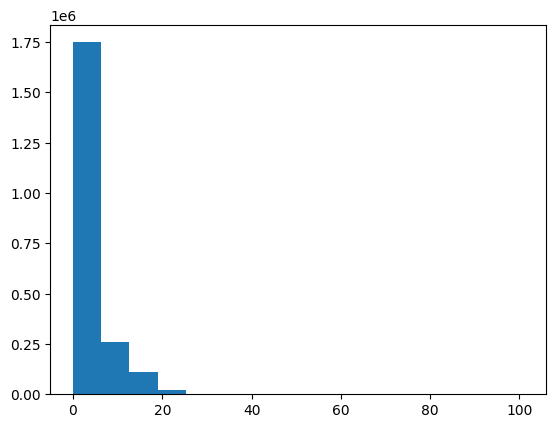

In [37]:
plt.hist(clean_data.tip_amount,16,histtype='bar'); # matplotlib is internally handels the conversion the column in the dataset to an array
                                # or suitable formate to ploting
                                
# Matplotlib has its own internal mechanisms to handle the visualization of data without altering the original dataset.

# plt.hist(clean_data.tip_amount.values)